# <ins> HeartRate Detection Algorithm </ins>

#### PPG (Photoplethysmography):
Photoplethysmography (PPG) is a non-invasive method of measuring blood volume changes in tissues using light. It works by shining light into the skin and measuring the amount of light absorbed or reflected by the blood vessels. PPG can be used to measure heart rate, oxygen saturation, and blood pressure. It is commonly used in pulse oximeters, wearable fitness trackers, and other medical devices. PPG signals are typically acquired at a sampling frequency of 50-1000 Hz and can be analyzed using signal processing techniques such as filtering, peak detection, and frequency analysis. PPG is a simple and inexpensive method of monitoring cardiovascular health and has a wide range of applications in both clinical and non-clinical settings.

### Algorithm:
Step0: Get Raw PPG signal </br>
Step1: Filter the PPG signal with a bandpass filter.</br>
Step2: Check signal quality by calculating Signal to Noise Ratio. </br>
Step3: Differentiate the filtered signal </br>
Step4: Removing Abnormalities </ins>
Step5: Square the differentiated  signal. </br>
Step6: Integrate the squared signal with a sliding window. </br>
Step7: Find the R-peaks in the integrated signal. </br>
Step8: Calculate the heart rate using the time difference between R-peaks. </br>

### Step0: Get Raw PPG signal

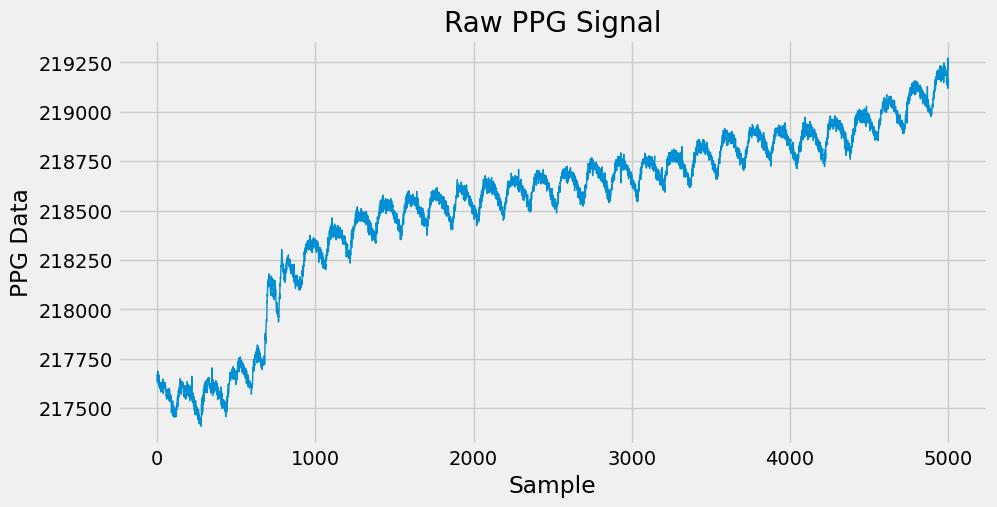

In [64]:
# Project Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

# Select channel from the dataset.
channel = 'IR (counts)'
max_samples = 5000

# Open CSV File Data
# df = pd.read_csv('good signals/2023-05-01-001S-13-31-14-S - Copy.csv')
df = pd.read_csv('good signals/2023-05-01-001S-16-32-10-S - Copy.csv')
# df = pd.read_csv('good signals/2023-05-01-001S-19-39-19-S - Copy.csv')
df.head()

# Data Sampled at 200Hz
# Getting 5K Samples = 25Seconds of Data
ppg_data = df[['Time (ms)', channel]]

ppg_data = ppg_data.iloc[:max_samples]

# Plot the PPG data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Raw PPG Signal")
plt.xlabel('Sample')
plt.ylabel('PPG Data')
plt.show()


 ### <ins> Step1: Filter the PPG signal with a bandpass filter.</br> </ins>
The purpose of filtering is to remove noise and unwanted components from the signal. A bandpass filter is used to pass only the frequency band of interest, which in this case is the heart rate. A typical bandpass filter used for PPG signals has a passband between 0.5 Hz and 5 Hz.

Cut off Frequency fc:</br>
PPG signal contains information mostly in rage of 0.5Hz(30bpm) to 5Hz(300bpm). In our application in most of cases choosing Fc = 5Hz gives us the best results since majority of the time heart rate range can't go outside between 30bpm(0.5Hz) to 300bpm(5Hz) so choosing 5Hz as cutoff frequency gives us best result. 

Sampling Frequency fs:</br>
Here we in this dataset data is sampled at 200Hz. So for this data Sampling frequency would be 200Hz. That means there are 5000 samples in 25 seconds time period.


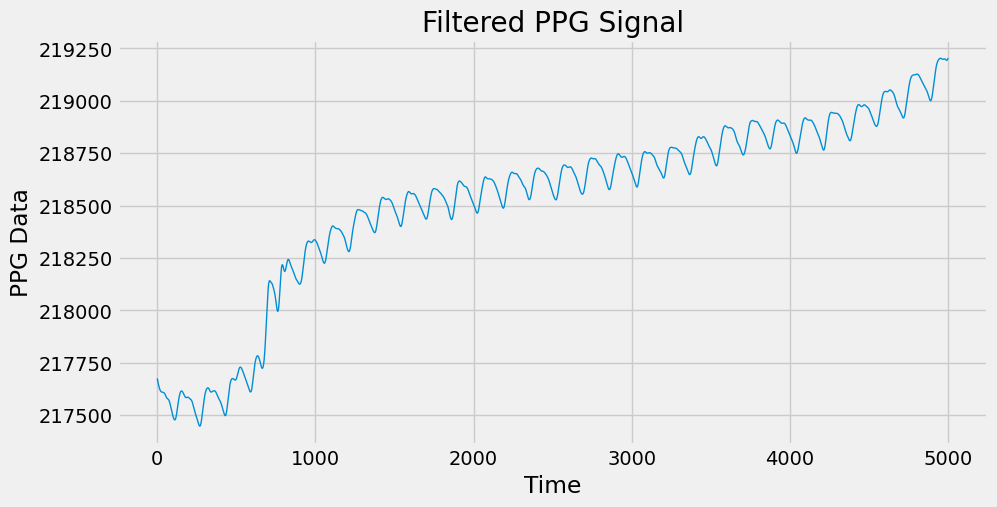

In [65]:
# Low-pass filter the raw signal to remove noise
fs = 200  # Sampling frequency
fc =  5 # Cutoff frequency
b, a = butter(2, 2 * fc / fs, 'low')

ppg_data_raw = ppg_data[channel]
#Applying LP Filter to ppg_data[channel]
ppg_data[channel] = filtfilt(b, a, ppg_data[channel])

ppg_data_filtered = ppg_data[channel]

# Plot the filtered_ppg data
plt.figure(figsize=(10,5))
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Filtered PPG Signal")
plt.xlabel('Time')
plt.ylabel('PPG Data')
plt.show()

### <ins> Step2: Check signal quality by calculating Signal to Noise Ratio. </br> </ins>
If Signal SNR is more than 25dB we consider it as good signal. If it falls below 25dB we give error.  

In [66]:
# Calculating SNR to find quality of a signal
# Noise signal
THRESHOLD = 25      #dB
noise_data = ppg_data_raw - ppg_data_filtered

signal_power = np.mean(np.abs(ppg_data_filtered)**2)
noise_power = np.mean(np.abs(noise_data)**2)
SNR = 10*np.log10(signal_power/noise_power)
print("SNR: ", SNR)
if SNR < THRESHOLD:
    print("Signal Quality is Bad!")
else: 
    print("Signal Quality is Good!")

SNR:  80.80674423231626
Signal Quality is Good!


### <ins> Step3: Differentiate the filtered signal </ins>
By differentiating the filtered PPG signal, we can enhance the QRS complex in the PPG signal, which can help in detecting the heartbeat accurately. The differentiation operation also introduces noise into the signal, which can be reduced using a smoothing operation like moving average or median filtering. 

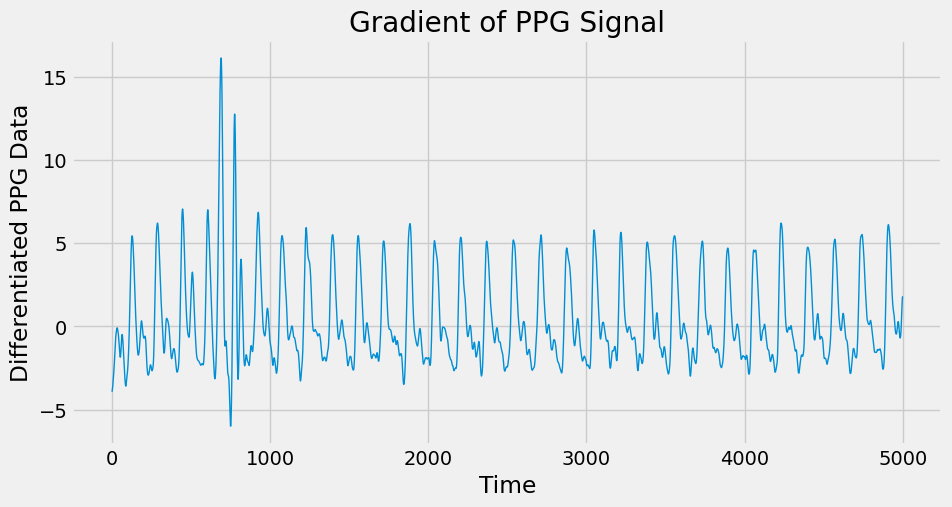

In [67]:
# Differentiate the filtered signal to emphasize the high-frequency components
ppg_data[channel] = np.gradient(ppg_data[channel])

# Plot the diff_ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Gradient of PPG Signal")
plt.xlabel('Time')
plt.ylabel('Differentiated PPG Data')
plt.show()

### <ins> Step4: Removing Abnormalities </ins>


0.30555455343324284
2.72608953612623
5.757733625685703


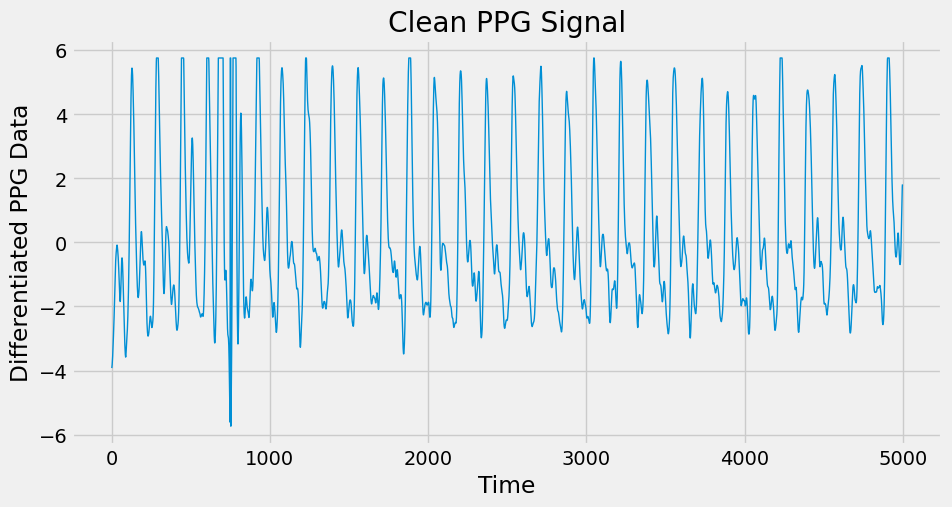

In [68]:
ppg_data_mean = np.mean(ppg_data[channel])
ppg_data_std = np.std(ppg_data[channel])

print(ppg_data_mean)
print(ppg_data_std)

threshold = ppg_data_mean + 2 * ppg_data_std  # set the threshold as 2 times the standard deviation above the mean
print(threshold)

ppg_data[channel] = ppg_data[channel].apply(lambda x: x if abs(x) <= threshold else threshold)

# Plot the diff_ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Clean PPG Signal")
plt.xlabel('Time')
plt.ylabel('Differentiated PPG Data')
plt.show()

### <ins> Step5: Square the differentiated  signal. </br> </ins>
Squaring the differentiated signal after it enhances the high-frequency components of the QRS complex and suppresses other low-frequency components in the signal, which improves the detection of the QRS complex in the signal. The squared signal produces prominent peaks where the QRS complex is located, which simplifies the detection process.

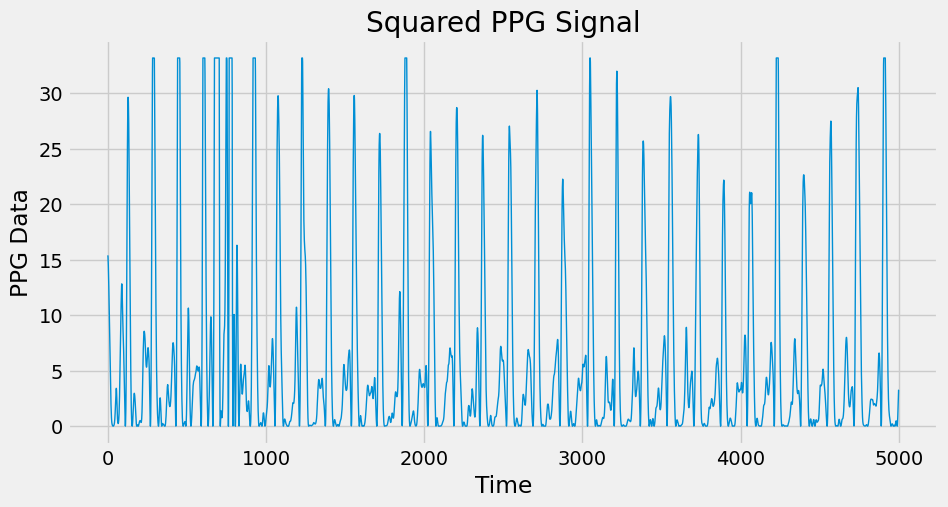

In [69]:
# Square the differentiated signal to enhance QRS complex
ppg_data[channel] = np.square(ppg_data[channel])

# Plot the square ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Squared PPG Signal")
plt.xlabel('Time')
plt.ylabel('PPG Data')
plt.show()

### <ins> Step6:  Integrate the squared signal with a sliding window. </br> </ins>
The purpose of this step is to smooth the signal and amplify the QRS complex even further. Here we have taken 50 window size means we can take moving average of 50 samples. 

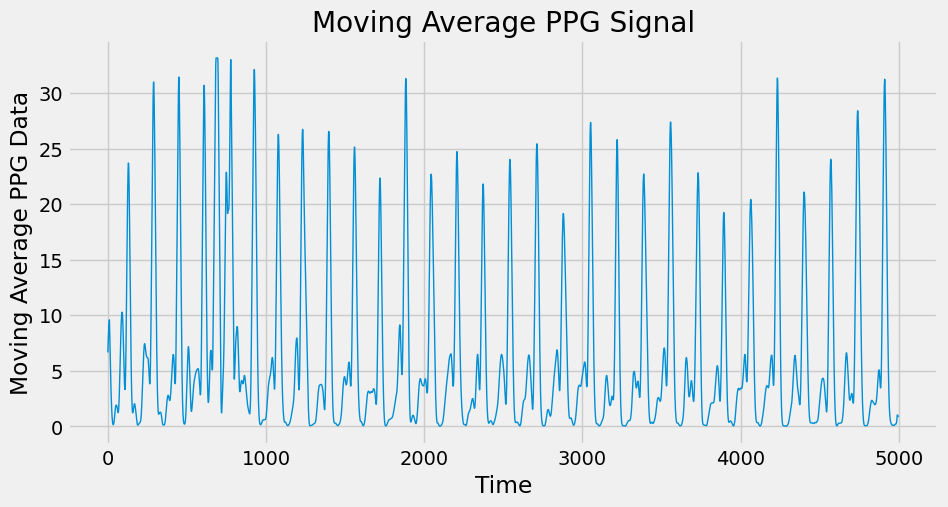

In [70]:
# Apply a moving average integration to smooth the signal
window_size = int(0.1 * fs)  # 50 window size
window = np.ones(window_size) / float(window_size)
ppg_data[channel] = np.convolve(ppg_data[channel], window, "same")

# Plot the diff_ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Moving Average PPG Signal")
plt.xlabel('Time')
plt.ylabel('Moving Average PPG Data')
plt.show()

### <ins> Step7: Find the R-peaks in the integrated signal. </br> </ins>
R peaks correspond to the highest point in the QRS complex, so we find the R peaks in the filtered signal to identify the location of each heartbeat. For this we can find_peaks() method which will return x axis positions of each peaks. Which we can use to calculate Inter Beat Interval(IBI)

In [71]:
# Find peaks in the integrated signal
ppg_peaks, _ = find_peaks(ppg_data[channel], distance=0.2*fs)
print("ppg_peaks:", ppg_peaks)
print("ppg_peaks size:", ppg_peaks.size)

# Get a list of Amplitude of peaks
ppg_peaks_amplitudes = [ppg_data[channel][i] for i in ppg_peaks]

max_peak_amplitude = max(ppg_peaks_amplitudes)
print("max_peak_amplitude:", max_peak_amplitude)

PEAK_AMPLITUDE_THRESHOLD = 0.4*max_peak_amplitude
print("PEAK_AMPLITUDE_THRESHOLD:", PEAK_AMPLITUDE_THRESHOLD)

ppg_peaks_refined = []
for ppg_peak in ppg_peaks:
    if(ppg_data[channel][ppg_peak] > PEAK_AMPLITUDE_THRESHOLD):
        # Amplitude is big enough to be considered as a peak
        ppg_peaks_refined.append(ppg_peak)

print(ppg_peaks_refined)

ppg_peaks: [  10   90  130  232  289  331  381  449  509  569  609  689  777  818
  864  926  991 1078 1122 1231 1348 1397 1437 1496 1559 1601 1680 1720
 1884 1929 1975 2044 2085 2207 2254 2306 2372 2420 2489 2542 2586 2661
 2712 2783 2839 2879 2926 2980 3051 3094 3153 3219 3326 3387 3438 3517
 3557 3601 3657 3731 3774 3853 3893 3935 4001 4064 4107 4166 4232 4274
 4343 4401 4470 4519 4570 4620 4668 4739 4789 4829 4910 4990]
ppg_peaks size: 82
max_peak_amplitude: 33.15149650435183
PEAK_AMPLITUDE_THRESHOLD: 13.260598601740734
[130, 289, 449, 609, 689, 777, 926, 1078, 1231, 1397, 1559, 1720, 1884, 2044, 2207, 2372, 2542, 2712, 2879, 3051, 3219, 3387, 3557, 3731, 3893, 4064, 4232, 4401, 4570, 4739, 4910]


### <ins> Step8: Calculate the heart rate using the time difference between R-peaks. </br> </ins>


In [72]:
# Minimum number of Peaks Check
total_time_seconds = max_samples/fs

# Minimum Heartbeat = 25bpm
# Maximum Heartbeat = 250bpm
HEARTRATE_LOWER_THRESHOLD = 25
HEARTRATE_HIGHER_THRESHOLD = 250

MIN_NO_OF_PEAKS_THRESHOLD = (HEARTRATE_LOWER_THRESHOLD/60)*total_time_seconds
MAX_NO_OF_PEAKS_THRESHOLD = (HEARTRATE_HIGHER_THRESHOLD/60)*total_time_seconds

print("MIN_NO_OF_PEAKS_THRESHOLD = ", MIN_NO_OF_PEAKS_THRESHOLD)
print("MAX_NO_OF_PEAKS_THRESHOLD = ", MAX_NO_OF_PEAKS_THRESHOLD)

TOTAL_PEAKS_DETECTED = len(ppg_peaks_refined)
print("TOTAL_PEAKS_DETECTED = ", TOTAL_PEAKS_DETECTED)

if (TOTAL_PEAKS_DETECTED < MIN_NO_OF_PEAKS_THRESHOLD) or (TOTAL_PEAKS_DETECTED > MAX_NO_OF_PEAKS_THRESHOLD):

    print("Heart rate for file sample_ppg.csv: Error")
else:
    # Compute the inter-beat interval (IBI) and heart rate (HR) from the peak locations
    ibi = np.diff(ppg_peaks_refined) / fs  # IBI in seconds
    hr = 60 / ibi  # HR in bpm

    mean_hr = np.mean(hr)      
    # Output the heart rate measurement
    print("Heart rate for file sample_ppg.csv:", np.mean(hr), "bpm") 





MIN_NO_OF_PEAKS_THRESHOLD =  10.416666666666668
MAX_NO_OF_PEAKS_THRESHOLD =  104.16666666666667
TOTAL_PEAKS_DETECTED =  31
Heart rate for file sample_ppg.csv: 77.6416128722565 bpm
